In [1]:
import re
import nltk
import spacy
import gensim
import pandas as pd
import seaborn as sns
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from gensim import corpora
from keybert import KeyBERT
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import Word2Vec, KeyedVectors, LdaModel, TfidfModel, LsiModel, Nmf, CoherenceModel
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF

d:\git\NLP-Disneyland-Reviews\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exploratory Data Analysis (EDA)

In [2]:
file_path = 'data/DisneylandReviews.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')
print(df.head())

   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   

                                         Review_Text               Branch  
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong  
1  Its been a while since d last time we visit HK...  Disneyland_HongKong  
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong  
3  HK Disneyland is a great compact park. Unfortu...  Disneyland_HongKong  
4  the location is not in the city, took around 1...  Disneyland_HongKong  


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB
None


In [4]:
print(df.describe())

          Review_ID        Rating
count  4.265600e+04  42656.000000
mean   3.188553e+08      4.217695
std    1.657092e+08      1.063371
min    1.398724e+06      1.000000
25%    1.743274e+08      4.000000
50%    2.907583e+08      5.000000
75%    4.489579e+08      5.000000
max    6.708014e+08      5.000000


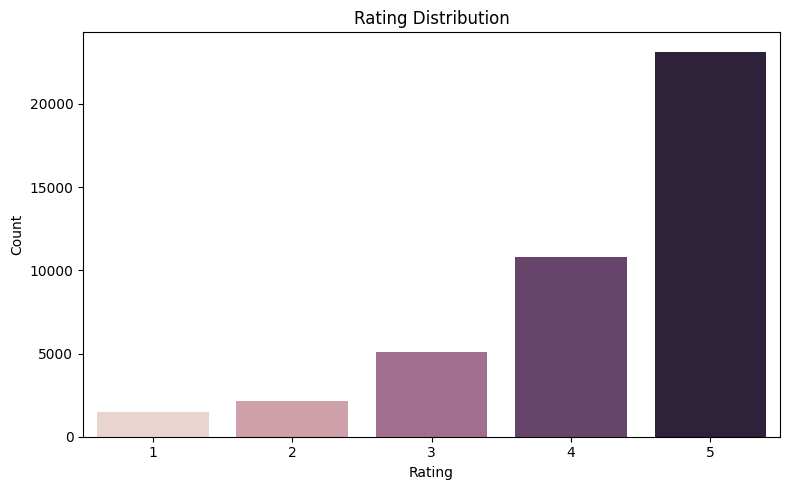

In [7]:
# Visualization 1: Rating Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Rating', hue='Rating', dodge=False, legend=False)
plt.title('Rating Distribution')
plt.ylabel('Count')
plt.xlabel('Rating')
plt.tight_layout()
plt.savefig('images/rating_distribution.png')
plt.show()

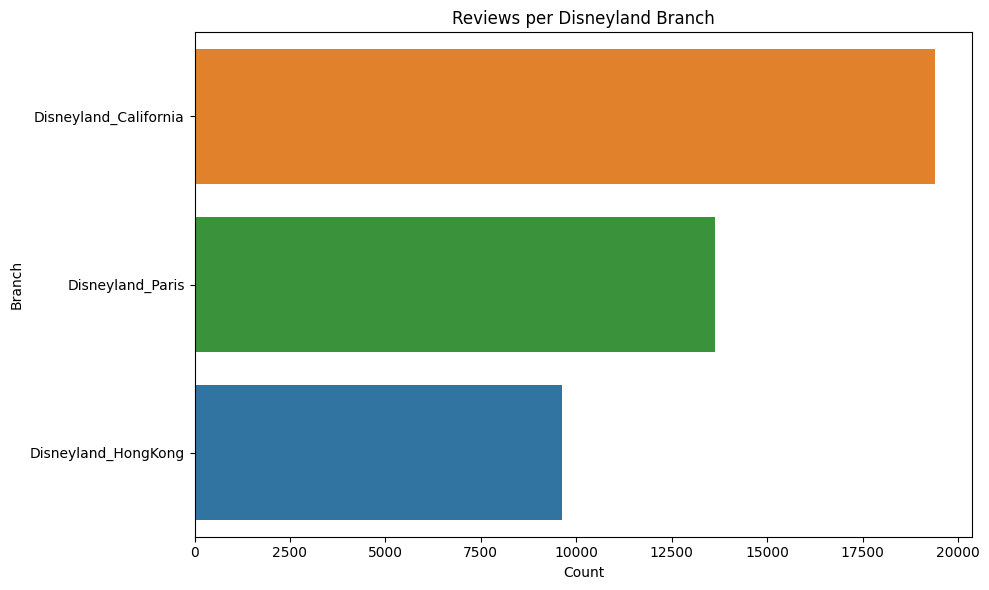

In [8]:
# Visualization 2: Reviews per Disneyland Branch
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='Branch', hue='Branch', dodge=False, order=df['Branch'].value_counts().index,
                legend=False)
plt.title('Reviews per Disneyland Branch')
plt.xlabel('Count')
plt.ylabel('Branch')
plt.tight_layout()
plt.savefig('images/branch_distribution.png')
plt.show()

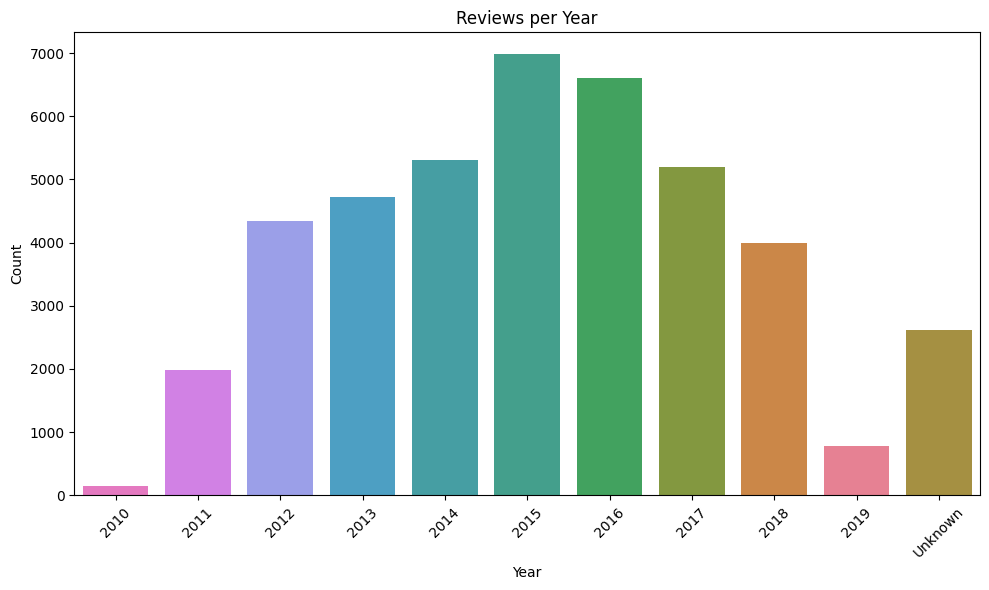

In [14]:
# Visualization 3: Reviews per Year
df['Year'] = df['Year_Month'].apply(lambda x: x.split('-')[0] if x != 'missing' else 'Unknown')
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Year', hue='Year', dodge=False, order=sorted(df['Year'].unique()), legend=False)
plt.title('Reviews per Year')
plt.ylabel('Count')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('images/year_distribution.png')
plt.show()

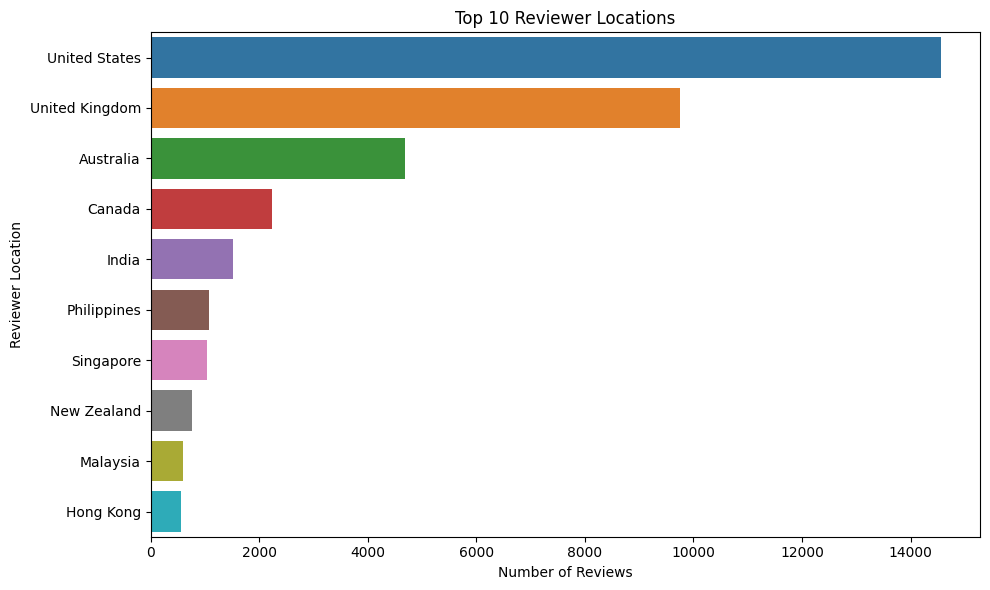

In [15]:
# Visualization 4: Reviews per Reviewer Location (Top 10)
top_locations = df['Reviewer_Location'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations, y=top_locations.index, hue=top_locations.index, dodge=False, legend=False)
plt.title('Top 10 Reviewer Locations')
plt.xlabel('Number of Reviews')
plt.ylabel('Reviewer Location')
plt.tight_layout()
plt.savefig('images/top_locations.png')
plt.show()

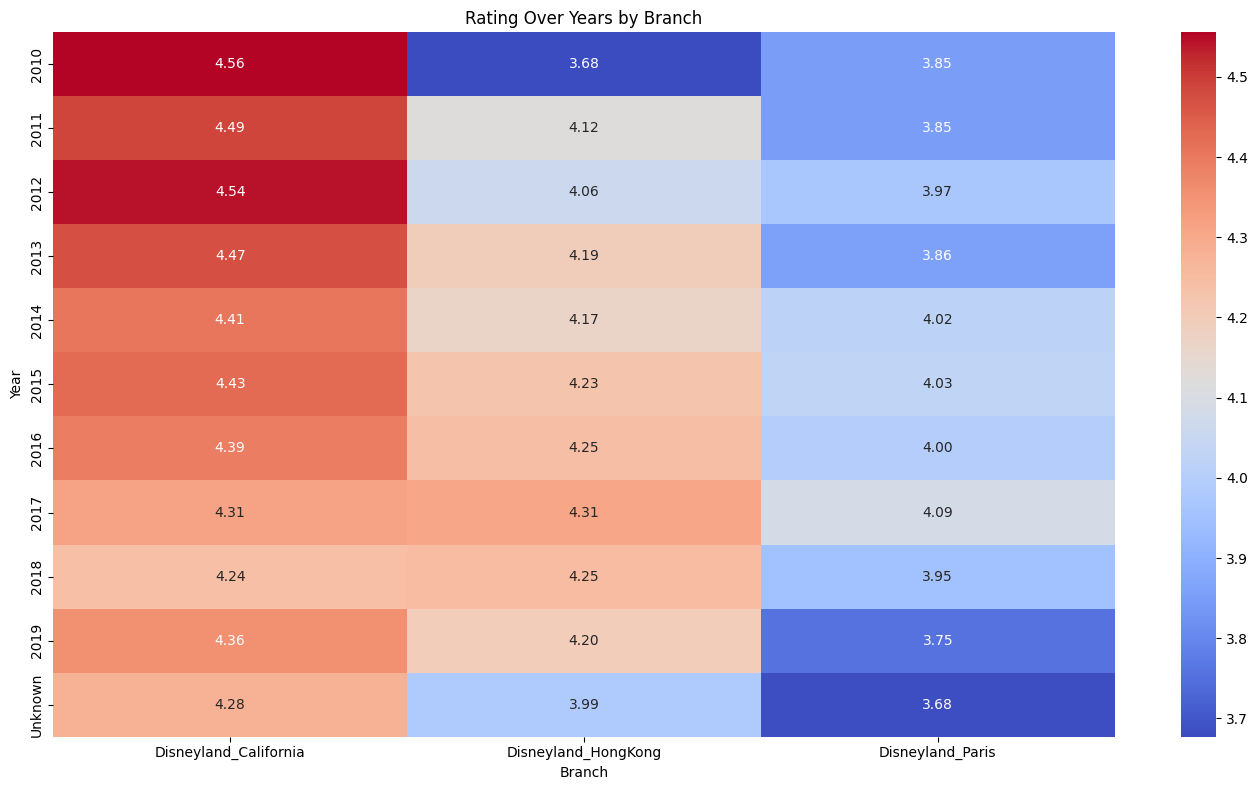

In [16]:
# Visualization 5: Rating Over Years by Branch
rating_per_year_branch = df.groupby(['Year', 'Branch'])['Rating'].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(rating_per_year_branch, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Rating Over Years by Branch')
plt.tight_layout()
plt.savefig('images/rating_over_years_by_branch.png')
plt.show()

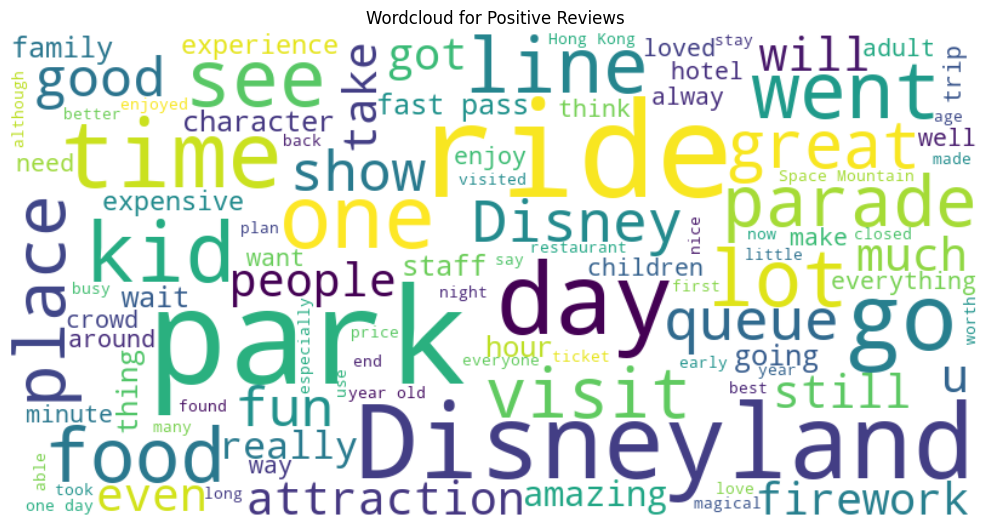

In [17]:
# Visualization 6: Wordcloud for positive reviews with 4 or 5 rating
positive_reviews = df[df['Rating'] >= 4]
positive_reviews_text = ' '.join(positive_reviews['Review_Text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white',
                        max_words=100).generate(positive_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud for Positive Reviews')
plt.tight_layout()
plt.savefig('images/wordcloud_positive_reviews.png')
plt.show()

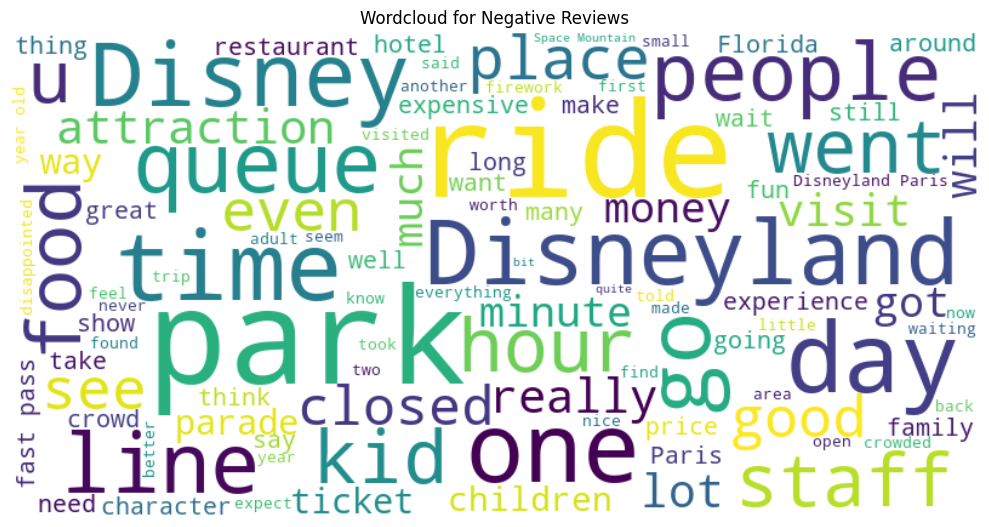

In [18]:
# Visualization 7: Wordcloud for negative reviews with 1, 2 or 3 rating
negative_reviews = df[df['Rating'] <= 3]
negative_reviews_text = ' '.join(negative_reviews['Review_Text'])
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white',
                        max_words=100).generate(negative_reviews_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Wordcloud for Negative Reviews')
plt.tight_layout()
plt.savefig('images/wordcloud_negative_reviews.png')
plt.show()

# Data preprocessing

In [1]:
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Loading the dataset
file_path = 'data/DisneylandReviews.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Load English tagger, and word vectors
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Custom stopwords
custom_stopwords = {'disney', 'land', 'disneyland', 'go', 'one', 'kid', 'world', 'I', 'day', 'thing', 'went', 'child', 'daughter'}
stop_words = set(stopwords.words('english')) | custom_stopwords

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Handling negations by creating bi-grams with negation word and subsequent word.
def handle_negations(text):
    # Define the negation pattern
    negation_pattern = re.compile(
        r"\b(not|no|never|none|cannot|can't|couldn't|shouldn't|won't|wouldn't|don't|doesn't|didn't|isn't|aren't|ain't"
        r")\s([a-z]+)\b",
        re.IGNORECASE
    )
    negated_form = r'\1_\2'  # E.g., "not_good"
    return negation_pattern.sub(negated_form, text)

# Function to preprocess text
def preprocess_text(text):
    try:
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = handle_negations(text)  # Handle negations
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in stop_words and token.isalnum()]
        lemmatized = nlp(' '.join(tokens))
        lemmatized = [token.lemma_ for token in lemmatized]
        return ' '.join(lemmatized)
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

# Apply preprocessing to the Review_Text column of the DataFrame
low_rating_threshold = 3
df = df[df['Rating'] <= low_rating_threshold]
df['Clean_Text'] = df['Review_Text'].apply(preprocess_text)

# Export to a new CSV file
df.to_csv('data/cleaned_reviews.csv', index=False)

C:\Users\moham\AppData\Local\Temp\ipykernel_12152\1562978333.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading 

# Bag of Words (BoW) model + LDA, NMF

Num Topics: 3, LDA Coherence: 0.3391516575461966, NMF Coherence: 0.3686611206073051
Num Topics: 4, LDA Coherence: 0.3289927553456592, NMF Coherence: 0.35739569508974356
Num Topics: 5, LDA Coherence: 0.3350193685709745, NMF Coherence: 0.3681317825549585
Num Topics: 6, LDA Coherence: 0.30114386665629644, NMF Coherence: 0.37042587842101343
Num Topics: 7, LDA Coherence: 0.292391861156886, NMF Coherence: 0.3863683134943354
Num Topics: 8, LDA Coherence: 0.27072939125221407, NMF Coherence: 0.4024064323809998
Num Topics: 9, LDA Coherence: 0.2950472468232664, NMF Coherence: 0.4006872940642767
Num Topics: 10, LDA Coherence: 0.3141966022126585, NMF Coherence: 0.37822129627422046


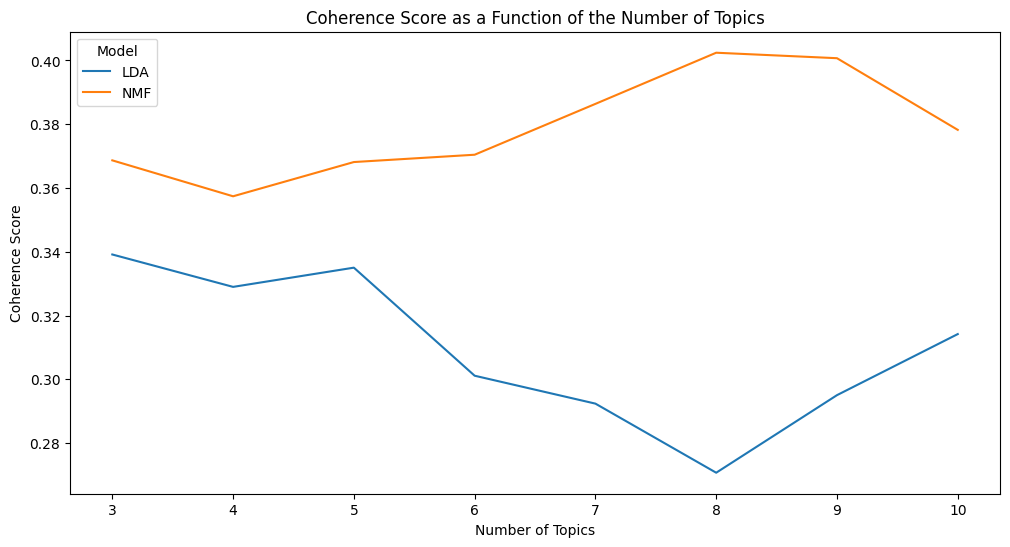


Best LDA Model Topics:
Topic 0: fast_pass wait_time wait_line year_old get_ride many_people could_not come_back long_line minute_wait
Topic 1: cast_member theme_park space_mountain ride_close thunder_mountain be_not visit_paris hong_kong I_ve customer_service
Topic 2: be_not year_old long_queue young_child could_not walk_around around_park would_not can_not queue_ride

Best NMF Model Topics:
Topic 0: wait_time hong_kong minute_wait 45_minute long_wait 30_minute long_line time_ride visit_park walk_around
Topic 1: wait_line cast_member line_get california_adventure line_ride long_line hour_wait fast_pass get_ride 30_minute
Topic 2: be_not cast_member I_m you_re ride_be main_street would_not that_s I_ve customer_service
Topic 3: fast_pass get_fast pass_ticket pass_system use_fast pass_ride ride_fast get_ride time_ride peter_pan
Topic 4: year_old 4_year 2_year 3_year 5_year 6_year 8_year long_queue old_son I_m
Topic 5: theme_park you_re I_ve hong_kong walk_around feel_like you_ve there_s 

In [2]:
import pandas as pd
from gensim.models import LdaModel, Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import numpy as np
from nltk import bigrams
import warnings

# Suppress warnings that do not affect the analysis
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the cleaned reviews
df = pd.read_csv('data/cleaned_reviews.csv')

# Loading list of strings containing the preprocessed documents
# df should be defined previously and should contain a 'Clean_Text' column
preprocessed_docs = df['Clean_Text'].tolist()

# Tokenized docs needed for coherence score calculation
tokenized_docs = [doc.split() for doc in preprocessed_docs]

# Generate bigrams and trigrams
bigram_docs = []
for doc in tokenized_docs:
    grams = list(bigrams(doc))
    bigram_docs.append(['_'.join(gram) for gram in grams])

# Create a Gensim dictionary from the tokenized docs
gensim_dictionary = Dictionary(bigram_docs)

# Filter extremes to mirror CountVectorizer's min_df and max_df
gensim_dictionary.filter_extremes(no_below=10, no_above=0.3)

# Convert the dictionary to a bag of words corpus for reference
gensim_corpus = [gensim_dictionary.doc2bow(doc) for doc in bigram_docs]

def compute_coherence(model, gensim_corpus, texts, coherence_measure='c_v'):
    coherence_model = CoherenceModel(model=model, texts=texts, corpus=gensim_corpus, dictionary=model.id2word, coherence=coherence_measure)
    return coherence_model.get_coherence()

# Set parameters and run the models
num_topics = range(3, 11) # Adjust the number of topics as needed
coherence_scores = {'LDA': [], 'NMF': []}
models = {'LDA': [], 'NMF': []}

for k in num_topics:
    lda_model = LdaModel(corpus=gensim_corpus, num_topics=k, id2word=gensim_dictionary, passes=10, random_state=42)
    models['LDA'].append(lda_model)
    coherence_scores['LDA'].append(compute_coherence(lda_model, gensim_corpus, bigram_docs))

    nmf_model = Nmf(corpus=gensim_corpus, num_topics=k, id2word=gensim_dictionary, passes=10, random_state=42)
    models['NMF'].append(nmf_model)
    coherence_scores['NMF'].append(compute_coherence(nmf_model, gensim_corpus, bigram_docs))

    print(f'Num Topics: {k}, LDA Coherence: {coherence_scores["LDA"][-1]}, NMF Coherence: {coherence_scores["NMF"][-1]}')

# Plot coherence scores
plt.figure(figsize=(12, 6))
plt.plot(num_topics, coherence_scores['LDA'], label='LDA')
plt.plot(num_topics, coherence_scores['NMF'], label='NMF')
plt.title('Coherence Score as a Function of the Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(title='Model', loc='best')
plt.show()

# Find the model with the highest coherence and print the topics
best_lda_index = np.argmax(coherence_scores['LDA'])
best_nmf_index = np.argmax(coherence_scores['NMF'])

best_lda_model = models['LDA'][best_lda_index]
best_nmf_model = models['NMF'][best_nmf_index]

# Print the topics from the best models
print("\nBest LDA Model Topics:")
for topic_idx, topic in enumerate(best_lda_model.show_topics(num_topics=best_lda_model.num_topics, formatted=False)):
    word_probs = topic[1]
    print("Topic %d:" % (topic_idx), " ".join([word for word,_ in word_probs]))

print("\nBest NMF Model Topics:")
for topic_idx, topic in enumerate(best_nmf_model.show_topics(num_topics=best_nmf_model.num_topics, formatted=False)):
    word_probs = topic[1]
    print("Topic %d:" % (topic_idx), " ".join([word for word, _ in word_probs]))

# Save models
best_lda_model.save('models/bow_lda_model')
best_nmf_model.save('models/bow_nmf_model')

# TF-IDF model + LDA, NMF

In [3]:
import pandas as pd
import gensim
from gensim.models import LdaModel, Nmf
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import numpy as np
from nltk import bigrams, trigrams
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer

# Suppress warnings that do not affect the analysis
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the cleaned reviews
df = pd.read_csv('data/cleaned_reviews.csv')

# Loading list of strings containing the preprocessed documents
# df should be defined previously and should contain a 'Clean_Text' column
preprocessed_docs = df['Clean_Text'].tolist()

# Tokenized docs needed for coherence score calculation
tokenized_docs = [doc.split() for doc in preprocessed_docs]

# Generate bigrams and trigrams
bigram_trigram_docs = []
for doc in tokenized_docs:
    grams = list(bigrams(doc)) + list(trigrams(doc))
    bigram_trigram_docs.append(['_'.join(gram) for gram in grams])

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Convert the documents to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(doc) for doc in bigram_trigram_docs])

# Convert the TF-IDF matrix to a Gensim corpus
gensim_corpus = gensim.matutils.Sparse2Corpus(tfidf_matrix, documents_columns=False)

# Create a Gensim dictionary from the bigram_trigram_docs
gensim_dictionary = Dictionary([' '.join(doc).split() for doc in bigram_trigram_docs])

# Filter extremes to mirror CountVectorizer's min_df and max_df
gensim_dictionary.filter_extremes(no_below=5, no_above=0.25)

# Convert the documents to a Gensim corpus
gensim_corpus = [gensim_dictionary.doc2bow(doc) for doc in [' '.join(doc).split() for doc in bigram_trigram_docs]]


def compute_coherence(model, gensim_corpus, texts, coherence_measure='c_v'):
    coherence_model = CoherenceModel(model=model, texts=texts, corpus=gensim_corpus, dictionary=model.id2word, coherence=coherence_measure)
    return coherence_model.get_coherence()

# Set parameters and run the models
num_topics = range(3, 11)  # Adjust the number of topics as needed
coherence_scores = {'LDA': [], 'NMF': []}
models = {'LDA': [], 'NMF': []}


# Compute coherence scores for different number of topics. pay attention toIndexError: index 942585 is out of bounds for axis 1 with size 8541
for k in num_topics:
    lda_model = LdaModel(corpus=gensim_corpus, num_topics=k, id2word=gensim_dictionary, passes=10, random_state=42)
    models['LDA'].append(lda_model)
    coherence_scores['LDA'].append(compute_coherence(lda_model, gensim_corpus, bigram_trigram_docs))

    nmf_model = Nmf(corpus=gensim_corpus, num_topics=k, id2word=gensim_dictionary, passes=10, random_state=42)
    models['NMF'].append(nmf_model)
    coherence_scores['NMF'].append(compute_coherence(nmf_model, gensim_corpus, bigram_trigram_docs))

    print(f'Num Topics: {k}, LDA Coherence: {coherence_scores["LDA"][-1]}, NMF Coherence: {coherence_scores["NMF"][-1]}')


# Plot coherence scores
plt.figure(figsize=(12, 6))
plt.plot(num_topics, coherence_scores['LDA'], label='LDA')
plt.plot(num_topics, coherence_scores['NMF'], label='NMF')
plt.title('Coherence Score as a Function of the Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend(title='Model', loc='best')
plt.show()

# Find the model with the highest coherence and print the topics
best_lda_index = np.argmax(coherence_scores['LDA'])
best_nmf_index = np.argmax(coherence_scores['NMF'])

best_lda_model = models['LDA'][best_lda_index]
best_nmf_model = models['NMF'][best_nmf_index]

# Print the topics from the best models
print("\nBest LDA Model Topics:")
for topic_idx, topic in enumerate(best_lda_model.show_topics(num_topics=best_lda_model.num_topics, formatted=False)):
    word_probs = topic[1]
    print("Topic %d:" % (topic_idx), " ".join([word for word, _ in word_probs]))

print("\nBest NMF Model Topics:")
for topic_idx, topic in enumerate(best_nmf_model.show_topics(num_topics=best_nmf_model.num_topics, formatted=False)):
    word_probs = topic[1]
    print("Topic %d:" % (topic_idx), " ".join([word for word, _ in word_probs]))

# Save models
best_lda_model.save('models/tfidf_lda_model')
best_nmf_model.save('models/tfidf_nmf_model')

Num Topics: 3, LDA Coherence: 0.5381140989581544, NMF Coherence: 0.5141136397075964


In [18]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(best_lda_model, gensim_corpus, gensim_dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.186880  0.022399       1        1  40.484055
1      0.071406 -0.153680       2        1  29.796218
0      0.115474  0.131281       3        1  29.719727, topic_info=                  Term         Freq        Total Category  logprob  loglift
1018         fast_pass  1629.000000  1629.000000  Default  30.0000  30.0000
226           year_old  1022.000000  1022.000000  Default  29.0000  29.0000
449             be_not  1547.000000  1547.000000  Default  28.0000  28.0000
437          wait_time   543.000000   543.000000  Default  27.0000  27.0000
8951     indiana_jones   406.000000   406.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
600            not_get   121.886991   393.238814   Topic3  -6.7026   0.0420
1210  thunder_mountain   121.788083   562.325832   Topic3  -6.7034  -0.3164
271         visit_park   114.739003   326.132978   Topic3  -6.7630   0.1687
18           hong_kong   110.440083   272.807504   Topic3  -6.8012   0.3091
313     space_mountain   110.990557   676.692689   Topic3  -6.7962  -0.5944

[259 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3163      1  0.025871  10_year_ago
3163      2  0.957236  10_year_ago
1740      1  0.969152       1_hour
1740      2  0.028645       1_hour
1740      3  0.004774       1_hour
...     ...       ...          ...
1536      2  0.363127       you_ve
1536      3  0.605212       you_ve
242       1  0.144593  young_child
242       2  0.686107  young_child
242       3  0.167274  young_child

[445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

# Word2Vec model + Kmeans

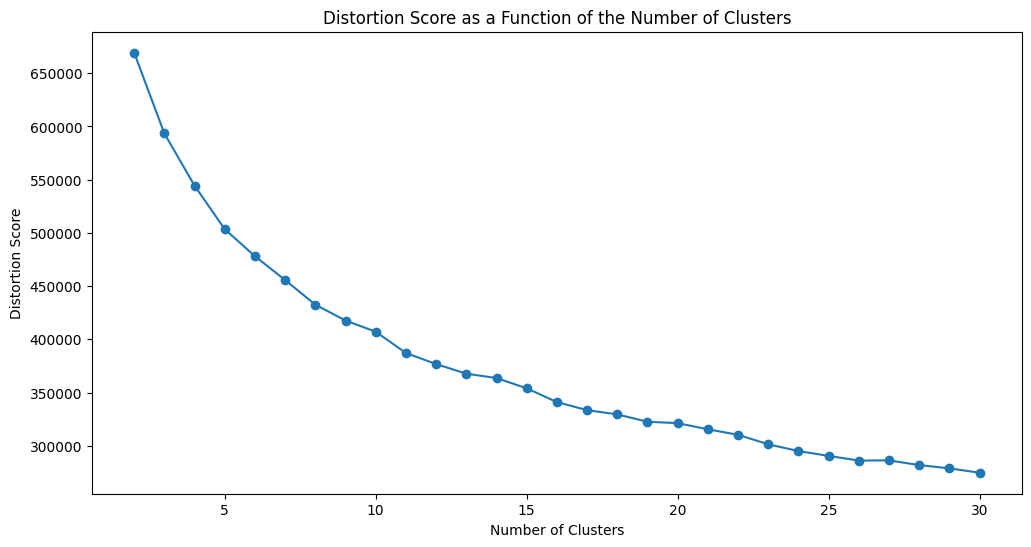

Best number of clusters: 30


d:\git\NLP-Disneyland-Reviews\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\git\NLP-Disneyland-Reviews\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


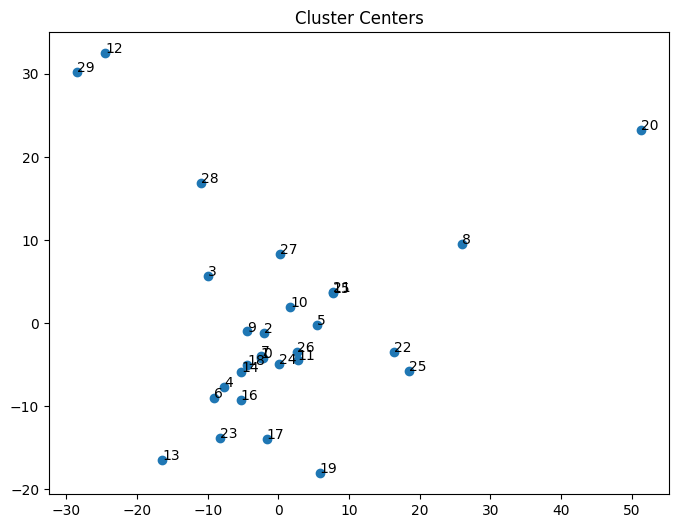

Cluster 0:
['well_worth', 'number_people', 'beat', '6_year_old', 'organise', 'benefit', 'strange', 'patience', 'tear', 'depend']
Cluster 1:
['20mins', 'big_deal', '2_min', '1hour', 'kiddie_ride', 'walk_straight', 'vary', 'would_ve', 'take_photo_character', 'go_to']
Cluster 2:
['head', 'case', 'group', 'make_sure', 'easy', 'extra', 'stay_hotel', 'fill', 'girl', 'drive']
Cluster 3:
['service', 'poor', 'offer', 'cheap', 'cold', 'consider', 'set', 'high', 'choice', 'awful']
Cluster 4:
['visit', 'family', 'spend', 'trip', 'year', 'last', 'since', 'may', 'day', 'holiday']
Cluster 5:
['every', 'least', 'able', 'full', 'almost', 'already', 'manage', 'avoid', 'plus', 'whilst']
Cluster 6:
['would', 'do_not', 'say', 'make', 'think', 'go', 'come', 'bad', 'know', 'feel']
Cluster 7:
['fast_track_ticket', 'autograph_book', 'let_start', 'beforehand', 'time_slot', 'arrange', 'rer', 'would_advise', 'open_10_am', 'extremely_long']
Cluster 8:
['time', 'long', 'hour', 'fast_pass', 'wait_line', '2_hour', 'f

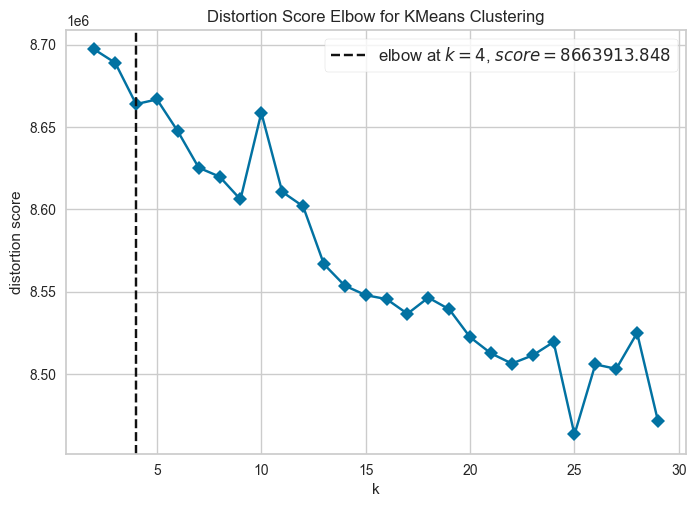

Best number of clusters: 4


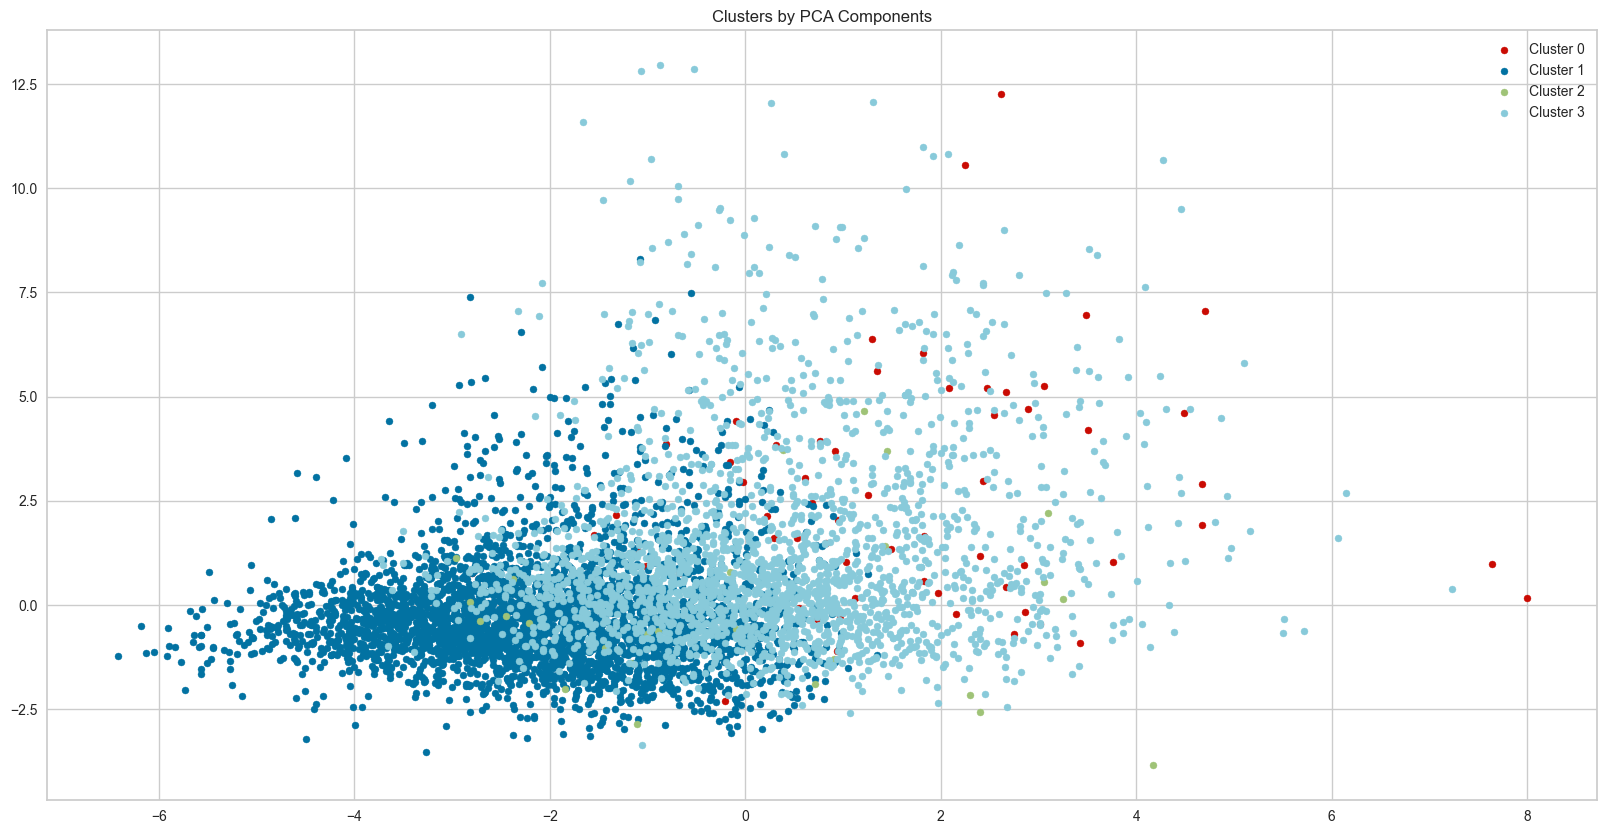

Top terms per cluster:
Cluster 0: difficulty, technical, shut, fix, ride, close, thunder, experience, mountain, arrive
Cluster 1: hong, kong, small, compare, hk, ocean, mtr, orlando, fun, mainland
Cluster 2: shoulder, crowd, step, literally, rope, outside, direction, vacation, realize, cause
Cluster 3: wait, line, pass, fast, minute, crowd, hour, ride, 45, people


In [19]:
import pandas as pd
from gensim.models import Word2Vec, Phrases
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import warnings
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.cluster import KElbowVisualizer

# Suppress warnings that do not affect the analysis
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the cleaned reviews
df = pd.read_csv('data/cleaned_reviews.csv')
preprocessed_docs = df['Clean_Text'].tolist()

# Tokenized docs
tokenized_docs = [doc.split() for doc in preprocessed_docs]

# Generate bigrams and trigrams using Gensim's Phrases
bigram = Phrases(tokenized_docs, min_count=10)
trigram = Phrases(bigram[tokenized_docs])
bigram_trigram_docs = [trigram[bigram[doc]] for doc in tokenized_docs]

# Train a Word2Vec model
model = Word2Vec(bigram_trigram_docs, vector_size=100, workers=4)

# Get the vectors for all words/phrases in the model
vectors = model.wv.vectors

# Standardize the vectors using StandardScaler
scaler = StandardScaler()
vectors_standardized = scaler.fit_transform(vectors)

# Fit KMeans models and calculate distortion for a range of cluster numbers using parallel processing
def calculate_distortion(k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectors_standardized)
    return k, kmeans.inertia_

num_clusters = range(2, 31)
distortion_scores = dict(Parallel(n_jobs=-1)(delayed(calculate_distortion)(k) for k in num_clusters))

# Plot distortion scores
plt.figure(figsize=(12, 6))
plt.plot(list(distortion_scores.keys()), list(distortion_scores.values()), marker='o')
plt.title('Distortion Score as a Function of the Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion Score')
plt.show()

# Find the best number of clusters using the elbow method
best_k = min(distortion_scores, key=distortion_scores.get)
print(f'Best number of clusters: {best_k}')

# Train a KMeans model with the best number of clusters
best_kmeans = KMeans(n_clusters=best_k, random_state=42)
best_kmeans.fit(vectors_standardized)

# Reduce the dimensionality of the cluster centers for visualization
pca = PCA(n_components=2)
cluster_centers_2d = pca.fit_transform(best_kmeans.cluster_centers_)

# Visualize the cluster centers
plt.figure(figsize=(8, 6))
plt.scatter(cluster_centers_2d[:, 0], cluster_centers_2d[:, 1])
for i, center in enumerate(cluster_centers_2d):
    plt.annotate(str(i), (center[0], center[1]))
plt.title('Cluster Centers')
plt.show()

# Assign each word to a cluster
word_to_cluster = {word: best_kmeans.labels_[i] for i, word in enumerate(model.wv.index_to_key)}

# Print the top words for each cluster
for cluster in range(best_k):
    print(f'Cluster {cluster}:')
    top_words = [word for word, clust in word_to_cluster.items() if clust == cluster]
    print(top_words[:10])  # Print```python


# Load dataset
df = pd.read_csv('data/cleaned_reviews.csv')
docs = df['Clean_Text'].values

# Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_norm = StandardScaler().fit_transform(tfidf.toarray())

# Optimal cluster finding
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30), timings=False)
visualizer.fit(tfidf_norm)
visualizer.show()

best_k = visualizer.elbow_value_
print(f"Best number of clusters: {best_k}")

# Clustering
km = KMeans(n_clusters=7)
clusters = km.fit_predict(tfidf_norm)

# PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(tfidf_norm)
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))

for i in range(best_k):
    points = np.array([scatter_plot_points[j] for j in range(len(scatter_plot_points)) if clusters[j] == i])
    ax.scatter(points[:, 0], points[:, 1], s=25, c=colors[i], label=f'Cluster {i}')

ax.legend()
plt.title('Clusters by PCA Components')
plt.show()

# Print top terms per cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(best_k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_terms)}")

# Analysis using Keybert

In [20]:
import pandas as pd
from keybert import KeyBERT
from collections import Counter
from tqdm import tqdm

# Load the cleaned reviews
df = pd.read_csv('data/cleaned_reviews.csv')
docs = df['Clean_Text'].tolist()

# Initialize KeyBERT with a specific model
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

# Extract keywords from each document using KeyBERT with a progress bar
doc_keywords = []
for doc in tqdm(docs, desc='Extracting keywords', unit='doc'):
    keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 3), stop_words='english')
    doc_keywords.append(keywords)


Extracting keywords: 100%|██████████| 8735/8735 [21:09<00:00,  6.88doc/s]


In [21]:
# Aggregate keywords for the entire dataset
all_keywords = [word for sublist in doc_keywords for word, _ in sublist]
keyword_freq = Counter(all_keywords)

# Get the most common keywords across the dataset
common_keywords = keyword_freq.most_common(30)
print("Most common keywords across the dataset:")
for keyword, freq in common_keywords:
    print(f"{keyword}: {freq}")

Most common keywords across the dataset:
visit paris: 123
theme park: 110
ride queue: 100
queue ride: 98
paris: 92
visit park: 88
amusement park: 76
park: 71
queue: 66
california adventure: 60
ride park: 58
disneyland: 53
ride attraction: 46
park ride: 45
hotel: 44
park queue: 41
disneyworld florida: 41
california adventure park: 41
ocean park: 40
fast pass: 40
trip paris: 40
visit hong kong: 39
disneyworld: 39
park paris: 38
hong kong: 36
hk: 35
walk park: 33
paris park: 33
fast pass ride: 33
ride fast pass: 32


In [22]:
# Concatenate documents to create a single text corpus
corpus = ' '.join(docs)

# Extract keywords from the concatenated corpus
corpus_keywords = kw_model.extract_keywords(corpus, keyphrase_ngram_range=(1, 3), stop_words='english', top_n=10)

# Print the extracted keywords from the concatenated corpus
print("\nKeywords representative of the entire corpus:")
for keyword, score in corpus_keywords:
    print(f"{keyword}: {score}")

# Bertopic

In [ ]:
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Load preprocessed data
df = pd.read_csv('data/cleaned_reviews.csv')

# Extract the reviews as a list
docs = df['Clean_Text'].tolist()

# Load a pre-trained sentence transformer model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Create BERTopic model
topic_model = BERTopic(embedding_model=sentence_model, language="english", calculate_probabilities=True, verbose=True)

# Fit the BERTopic model
topics, probs = topic_model.fit_transform(docs)

# Get an overview of all the topics that the model has found
topic_info = topic_model.get_topic_info()

# Show the top 10 topics
for topic_num in topic_info['Topic'][:10]:
    if topic_num != -1:  # Exclude the -1 topic which contains outliers
        print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)}\n")

# Save the model for future use
topic_model.save("models/bertopic_model")

# Save the topic modeling results to a CSV file for further analysis
df['Topic'] = topics
df['Topic_Probability'] = probs.max(axis=1)
df.to_csv('data/bertopic_results.csv', index=False)


2024-03-01 14:16:59,257 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 273/273 [01:37<00:00,  2.79it/s]
2024-03-01 14:18:37,418 - BERTopic - Embedding - Completed ✓
2024-03-01 14:18:37,419 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-03-01 14:19:00,279 - BERTopic - Dimensionality - Completed ✓
2024-03-01 14:19:00,282 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-03-01 14:19:01,481 - BERTopic - Cluster - Completed ✓
2024-03-01 14:19:01,495 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-03-01 14:19:02,135 - BERTopic - Representation - Completed ✓


Topic 0: [('kong', 0.03897897948042326), ('hong', 0.03892600484096399), ('hk', 0.030726218167951756), ('small', 0.017420939620736535), ('visit', 0.015962068754474344), ('chinese', 0.012981026411710164), ('park', 0.012958034524176385), ('ride', 0.012138334482315917), ('not', 0.011486212291083006), ('compare', 0.010802624205033655)]

Topic 1: [('paris', 0.039637933371134304), ('park', 0.01811429135716939), ('visit', 0.01416455193523221), ('ride', 0.01378406262441285), ('not', 0.013160375251949599), ('close', 0.013015863187574162), ('time', 0.0123704997028495), ('would', 0.011366357502825903), ('florida', 0.011222537564535357), ('attraction', 0.010842046006219437)]

Topic 2: [('queue', 0.014552191376354554), ('get', 0.013299316084363294), ('hotel', 0.011750933931771939), ('ride', 0.01114082155639031), ('not', 0.011065219202148252), ('time', 0.010948954170043023), ('park', 0.010189408685126012), ('child', 0.009979058814810806), ('take', 0.009244179420307882), ('do', 0.009120949832019023)]


In [ ]:
# Visualize the topics
topic_model.visualize_topics()

In [ ]:
# Visualize the topic barchart
topic_model.visualize_barchart(top_n_topics=16)

In [ ]:
# Visualize the topic heatmap
topic_model.visualize_heatmap()